# RNN for Smoothed Sunspot Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

2023-02-09 14:47:19.262735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values
yerr = np.zeros(len(X))

df.drop(columns=['Unnamed: 0'], inplace=True) 
# removes the unnecessary column
df.set_index("Year", inplace=True)


#df.head(), df.tail()

## Data Preprocessing

In [4]:
limit = 70000
skips = 28 # 1 data point per luna cycle
train_data = df.iloc[:limit:skips]
validation_data = df.iloc[limit::skips]

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [6]:
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(validation_data)

In [7]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [8]:
# define generator
n_input = 11 * 12 # 11 years 
n_features = 1 # we are only using 1 timeseries to make our predictions
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [9]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

X.shape

Given the Array: 
[0.1263682  0.12394294 0.12151768 0.11909242 0.11666716 0.1142419
 0.11181664 0.10939138 0.10696612 0.10454086 0.1021156  0.09969034
 0.09726508 0.09483982 0.09241456 0.0899893  0.08756405 0.08513879
 0.08271353 0.08028827 0.07786301 0.07543775 0.07301249 0.07058723
 0.06816197 0.06573671 0.06331145 0.06201998 0.060503   0.06106645
 0.05982108 0.05698361 0.05190677 0.04829202 0.04698308 0.04441722
 0.04254772 0.03949642 0.03890696 0.03753446 0.0356534  0.03475477
 0.03442826 0.03293728 0.0313914  0.02761195 0.02417635 0.02171451
 0.01897816 0.0175941  0.01513803 0.01284667 0.01183246 0.01105518
 0.00859912 0.00783051 0.00666605 0.00502193 0.00388925 0.00271612
 0.00228847 0.         0.00187817 0.00339804 0.00306864 0.00230581
 0.00194174 0.00373033 0.00564895 0.00566051 0.00605059 0.00783051
 0.01033281 0.0134419  0.01606267 0.0174294  0.01689195 0.01697286
 0.01930756 0.0208361  0.02274316 0.02533504 0.0269127  0.02994088
 0.03311932 0.03818459 0.04405314 0.04904329 

(1, 132, 1)

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [12]:
# define model
model = Sequential() # adds layers in a sequence
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features))) # maybe try elu?
# 100 neurons
model.add(Dense(1))
# 1 layer
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [13]:
# fit model
epochs = 10
model.fit(generator, epochs=epochs)

Epoch 1/10
2368/2368 [==============================] - 107s 45ms/step - loss: 8.6917e-04
Epoch 2/10
2368/2368 [==============================] - 105s 44ms/step - loss: 1.6692e-04
Epoch 3/10
2368/2368 [==============================] - 103s 44ms/step - loss: 1.1081e-04
Epoch 4/10
2368/2368 [==============================] - 109s 46ms/step - loss: 9.3560e-05
Epoch 5/10
2368/2368 [==============================] - 104s 44ms/step - loss: 6.8324e-05
Epoch 6/10
2368/2368 [==============================] - 107s 45ms/step - loss: 5.0213e-05
Epoch 7/10
2368/2368 [==============================] - 107s 45ms/step - loss: 4.5401e-05
Epoch 8/10
2368/2368 [==============================] - 113s 48ms/step - loss: 3.2823e-05
Epoch 9/10
2368/2368 [==============================] - 105s 44ms/step - loss: 3.4120e-05
Epoch 10/10
2368/2368 [==============================] - 108s 45ms/step - loss: 2.9909e-05


In [23]:
'''
path_checkpoint = "LSTM_model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=validation_data,
    callbacks=[es_callback, modelckpt_callback],
)
'''

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

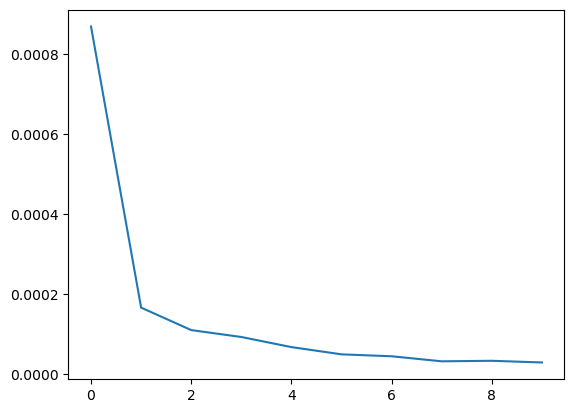

In [14]:
loss_per_epoch = model.history.history['loss']
#val_loss_per_epoch = model.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [15]:
last_train_batch = scaled_train[-n_input:] 
# take the last n_input month of values, to make 
# predictions on the 1st test set

In [23]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [24]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 62ms/step


array([[0.0592775]], dtype=float32)

In [35]:
validation_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(validation_data)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    validation_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [36]:
validation_predictions
# NOTE: these predictions are in the range 0-1
# we need to convert it back 

[array([0.0592775], dtype=float32),
 array([0.06367176], dtype=float32),
 array([0.0683149], dtype=float32),
 array([0.07314919], dtype=float32),
 array([0.0781336], dtype=float32),
 array([0.08323716], dtype=float32),
 array([0.08843543], dtype=float32),
 array([0.09370786], dtype=float32),
 array([0.09903631], dtype=float32),
 array([0.10440405], dtype=float32),
 array([0.10979521], dtype=float32),
 array([0.11519459], dtype=float32),
 array([0.12058754], dtype=float32),
 array([0.12599358], dtype=float32),
 array([0.13155662], dtype=float32),
 array([0.1372793], dtype=float32),
 array([0.14316055], dtype=float32),
 array([0.14919484], dtype=float32),
 array([0.155372], dtype=float32),
 array([0.16167785], dtype=float32),
 array([0.168095], dtype=float32),
 array([0.1746036], dtype=float32),
 array([0.18118201], dtype=float32),
 array([0.18780723], dtype=float32),
 array([0.19445547], dtype=float32),
 array([0.20110226], dtype=float32),
 array([0.20772274], dtype=float32),
 array([0.

In [37]:
true_predictions = scaler.inverse_transform(validation_predictions)

In [38]:
validation_data['Predictions'] = true_predictions

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_11734/2311742674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Predictions'] = true_predictions


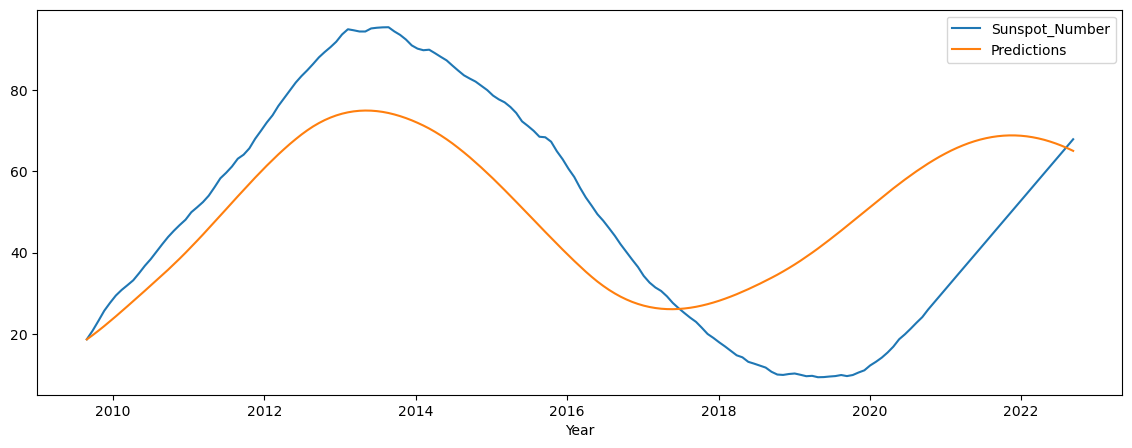

In [39]:
validation_data.plot(figsize=(14,5));